In [1]:
from __future__ import annotations

"""Generate overview statistics and figures for the mined PR dataset."""

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.dates as mdates

# –– Nature-ready styling
mpl.rcParams.update({
    # font
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times'],
    'mathtext.fontset': 'stix',
    # axes
    'axes.linewidth': 1.0,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    # ticks
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    # legend
    'legend.fontsize': 13,
    'legend.title_fontsize': 11,
    # figure
    'figure.dpi': 300,
})
sns.set_style("whitegrid")  # subtle grid

from helper import CSV_DIR, FIG_DIR, SCOPE_DIR, filter_pr_df, COLOR_MAP

SELECTED_AGENTS = [
    "OpenAI_Codex",
    "Devin",
    "Copilot",
    "Cursor",
    "Claude_Code",
    "Human",
]

In [6]:
def _load_real_users() -> pd.DataFrame:
    """Return dataframe of real user mappings if available."""
    fp = CSV_DIR / "real_users.csv"
    if not fp.exists():
        return pd.DataFrame(columns=["agent", "pr_id", "user"])
    return pd.read_csv(fp, dtype={"pr_id": str})


def _apply_real_users(df: pd.DataFrame, agent: str, real_users: pd.DataFrame) -> pd.DataFrame:
    """Merge *df* with real user names for *agent* if available."""
    subset = real_users[real_users["agent"] == agent]
    if subset.empty:
        return df
    df = df.copy()
    df["id"] = df["id"].astype(str)
    df = df.merge(subset[["pr_id", "user"]], left_on="id", right_on="pr_id", how="left")
    df["user"] = df["user_y"].combine_first(df["user_x"])
    return df.drop(columns=["pr_id", "user_x", "user_y"])


def load_prs(agent: str, popular: bool = False, scope: bool = False) -> pd.DataFrame:
    """Return PR dataframe for *agent*.

    If *popular* is True, read the ``*_popular_prs.csv`` file. Otherwise
    read ``*_prs.csv``.
    """
    if scope:
        fp = SCOPE_DIR / agent / "prs.csv"
        if not fp.exists():
            raise FileNotFoundError(fp)
        df = pd.read_csv(fp, parse_dates=["created_at"])
    else:
        suffix = "_popular_prs.csv" if popular else "_prs.csv"
        fp = CSV_DIR / f"{agent}{suffix}"
        if not fp.exists():
            raise FileNotFoundError(fp)
        df = pd.read_csv(fp, parse_dates=["created_at"])
    return filter_pr_df(df, agent)


def agent_summary(agent: str, popular: bool = False, real_users: pd.DataFrame | None = None, scope: bool = False) -> dict:
    """Return summary stats for *agent* as a dictionary."""
    df = load_prs(agent, popular, scope)

    if real_users is not None and not real_users.empty:
        df = _apply_real_users(df, agent.replace("_popular", ""), real_users)
    # deduplication is needed
    df = df.drop_duplicates(subset=["id"])
    total = len(df)
    open_count = (df["state"] == "open").sum()
    merged_count = df["merged_at"].notna().sum()
    closed_unmerged_count = ((df["state"] == "closed") & (df["merged_at"].isna())).sum()

    return {
        "agent": agent,
        "prs": total,
        "pct_open": open_count / total * 100 if total else 0.0,
        "pct_closed": closed_unmerged_count / total * 100 if total else 0.0,
        "pct_merged": merged_count / total * 100 if total else 0.0,
        "developers": df["user"].nunique(dropna=True),
        "repos": df["repo_url"].nunique(dropna=True),
    }


def build_summary(popular: bool = False, scope: bool = False) -> pd.DataFrame:
    """Create a summary table for all agents."""
    real_users = _load_real_users()
    rows = []
    if scope:
        agents = [a for a in SELECTED_AGENTS if (SCOPE_DIR / a / "prs.csv").exists()]
    else:
        agents = [fp.stem.replace("_prs", "") for fp in CSV_DIR.glob("*_prs.csv") if fp.stem.replace("_prs", "") in SELECTED_AGENTS]
    for agent in agents:
        try:
            rows.append(agent_summary(agent, popular, real_users, scope))
        except FileNotFoundError:
            continue
    return pd.DataFrame(
        rows,
        columns=[
            "agent",
            "prs",
            "pct_open",
            "pct_closed",
            "pct_merged",
            "developers",
            "repos",
        ],
    ).sort_values("agent")



def plot_over_time(popular: bool = False, scope: bool = False) -> None:
    """Plot PR trends with clean lines + a compact right-side legend."""
    if scope:
        agents = [a for a in SELECTED_AGENTS if (SCOPE_DIR / a / "prs.csv").exists()]
    else:
        # pattern = "*_popular_prs.csv" if popular else "*_prs.csv"
        # files = [f for f in CSV_DIR.glob(pattern) if "_popular_prs" not in f.stem]
        # agents = [fp.stem.replace("_popular_prs", "").replace("_prs", "") for fp in files if fp.stem.replace("_popular_prs", "").replace("_prs", "") in SELECTED_AGENTS]
        agents = [a for a in SELECTED_AGENTS if (CSV_DIR / f"{a}_prs.csv").exists()]

    # Color + linestyle maps (as before)
    # colors     = sns.color_palette("tab10", n_colors=len(agents))
    # linestyles = ["--", "--", "-.", ":", (0, (3,1,1,1)), (0, (5,1))]
    style_map  = {
        # a: {"color": COLOR_MAP[a], "linestyle": linestyles[i % len(linestyles)]}
        a: {"color": COLOR_MAP[a]}
        for i, a in enumerate(agents)
    }

    def _one_plot(cumulative: bool, fname: str, ylabel: str, title: str):
        fig, ax = plt.subplots(figsize=(6, 4))

        # draw each agent
        for agent in agents:
            if agent == "Human":
                continue
            try:
                df = load_prs(agent, popular, scope)
            except FileNotFoundError:
                continue

            grp = df.groupby(df["created_at"].dt.date).size()
            y   = grp.cumsum() if cumulative else grp
            x   = pd.to_datetime(grp.index)

            ax.plot(
                x, y,
                label=agent.replace("_", " "),
                linewidth=2.2,
                **style_map[agent]
            )

        # clean up spines & grid
        for sp in ("top", "right"):
            ax.spines[sp].set_visible(False)
        ax.grid(axis="y", color="0.85", linestyle="--", linewidth=0.7)
        ax.grid(axis="x", visible=False)

        # nice monthly ticks
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        fig.autofmt_xdate(rotation=30, ha="right")
        
        # For paper
        # ax.set_xlabel("Date", labelpad=6)
        # ax.set_ylabel(ylabel, labelpad=6)
        # ax.set_title(title, pad=10, fontsize=14)
        # For poster
        ax.set_yticks([0, 100000, 200000, 300000, 400000])
        ax.set_yticklabels(["0", "100k", "200k", "300k", "400k"])

        # compact, right-side legend
        leg = ax.legend(
            title="Agent",
            loc='upper left',
            # bbox_to_anchor=(1.02, 1),
            frameon=True,
            ncol=1,
            fontsize=9,
            title_fontsize=10
        )

        # make sure legend text doesn’t get cut off
        fig.tight_layout()
        FIG_DIR.mkdir(exist_ok=True, parents=True)
        out = FIG_DIR / fname
        fig.savefig(out, dpi=300)
        fig.savefig(out.with_suffix('.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)
        print("Wrote", out)

    # daily
    scope_suffix = '_popular' if scope else ''
    # cumulative
    _one_plot(
        cumulative=True,
        fname=f"pr_cumulative{'_popular' if popular else ''}{scope_suffix}.pdf",
        ylabel="Cumulative PR Count",
        title=f"Cumulative PR Count{' (Popular Repos Only)' if (popular or scope) else ''}"
    )

def generate_sorted_latex_with_total(df, all_pr_data: pd.DataFrame):
    """
    Generate LaTeX table with correct global totals avoiding double counting.

    Parameters:
    - df: Per-agent summary DataFrame ['agent', 'prs', 'repos', 'developers']
    - all_pr_data: Combined DataFrame of all PRs with columns ['id', 'repo_url', 'user', 'created_at']

    Returns:
    - LaTeX formatted table string
    """

    # Step 1: Sort per-agent summary by 'prs' descending
    df_sorted = df.sort_values(by='prs', ascending=False).reset_index(drop=True)

    # Step 2: Compute accurate global unique counts
    dedup = all_pr_data.drop_duplicates(subset=['id'])
    total_row = {
        'agent': 'Total',
        'prs': len(dedup),
        'developers': dedup['user'].nunique(dropna=True),
        'repos': dedup['repo_url'].nunique(dropna=True),
        'pct_open': (dedup['state'] == 'open').sum() / len(dedup) * 100 if len(dedup) else 0.0,
        'pct_merged': dedup['merged_at'].notna().sum() / len(dedup) * 100 if len(dedup) else 0.0,
        'pct_closed':
            (((dedup['state'] == 'closed') & dedup['merged_at'].isna()).sum())
            / len(dedup) * 100 if len(dedup) else 0.0,
    }

    # Step 3: Append total row
    df_total = pd.concat([df_sorted, pd.DataFrame([total_row])], ignore_index=True)

    # Step 4: Format numbers with commas
    for col in ['prs', 'repos', 'developers']:
        df_total[col] = df_total[col].apply(lambda x: f"{x:,}")

    for col in ['pct_open', 'pct_closed', 'pct_merged']:
        df_total[col] = df_total[col].apply(lambda x: f"{x:.1f}")

    df_total['agent'] = df_total['agent'].str.replace('_popular', '', regex=False).str.replace('_', ' ')
    df_total.rename(
        columns={
            'agent': 'Agent',
            'prs': '\# PR',
            'repos': '\# Repository',
            'developers': '\# Developers',
            'pct_open': '\% Open PR',
            'pct_closed': '\% Closed PR',
            'pct_merged': '\% Merged PR',
        },
        inplace=True,
    )

    # Step 5: Export LaTeX table
    latex_table = df_total.to_latex(index=False, escape=False)

    return latex_table

In [7]:
def main(args_scope):
    summary = build_summary(scope=args_scope)
    base_dir = SCOPE_DIR if args_scope else CSV_DIR
    if summary.empty:
        print("No CSV files found in", base_dir)
        return

    print(summary.to_string(index=False))
    out_csv = base_dir / ("summary_scope.csv" if args_scope else "summary.csv")
    summary.to_csv(out_csv, index=False)

    # Collect all PR data
    real_users = _load_real_users()
    all_prs = []
    all_popular_prs = []
    if args_scope:
        for agent in SELECTED_AGENTS:
            fp = SCOPE_DIR / agent / "prs.csv"
            if not fp.exists():
                continue
            df = pd.read_csv(fp, parse_dates=["created_at"])
            df = filter_pr_df(df, agent)
            if not real_users.empty:
                df = _apply_real_users(df, agent, real_users)
            all_prs.append(df)
    else:
        for fp in CSV_DIR.glob("*_prs.csv"):
            if "_popular_prs" in fp.stem:
                print(f"Skipping {fp} as it is a popular PR file")
                continue
            agent = fp.stem.replace("_popular_prs", "").replace("_prs", "")
            if agent not in SELECTED_AGENTS:
                continue
            try:
                df = pd.read_csv(fp, parse_dates=["created_at"])
                df = filter_pr_df(df, agent)
                if not real_users.empty:
                    df = _apply_real_users(df, agent, real_users)
                if "popular" in fp.stem:
                    all_popular_prs.append(df)
                else:
                    all_prs.append(df)
            except Exception as e:
                print(f"Skipping {fp} due to error: {e}")

    if not all_prs:
        print("No PR data found.")
        return

    combined_df = pd.concat(all_prs, ignore_index=True)
    # combined_popular_df = pd.concat(all_popular_prs, ignore_index=True) if all_popular_prs else pd.DataFrame()

    popular_mask = summary['agent'].apply(lambda x: x.endswith("popular")) if not args_scope else pd.Series([False]*len(summary))

    print("Summary of PRs per agent:")
    print(generate_sorted_latex_with_total(summary[~popular_mask], combined_df))

    # print("Summary of popular repo PRs per agent:")
    # print(generate_sorted_latex_with_total(summary[popular_mask], combined_popular_df))

    print(f"Wrote {out_csv}")

    plot_over_time(popular=False, scope=args_scope)

       agent    prs  pct_open  pct_closed  pct_merged  developers  repos
 Claude_Code   1509  7.819748   17.031146   75.149105         585    645
     Copilot  16531 18.135624   19.726574   62.137802           1   3097
      Cursor   1981 14.588592   10.651186   74.760222         753    828
       Devin  24893  3.816334   30.490499   65.693167           1   3857
OpenAI_Codex 411621  7.933026    5.891585   86.175389       41619  53702
Summary of PRs per agent:
\begin{tabular}{lllllll}
\toprule
Agent & \# PR & \% Open PR & \% Closed PR & \% Merged PR & \# Developers & \# Repository \\
\midrule
OpenAI Codex & 411,621 & 7.9 & 5.9 & 86.2 & 41,619 & 53,702 \\
Devin & 24,893 & 3.8 & 30.5 & 65.7 & 1 & 3,857 \\
Copilot & 16,531 & 18.1 & 19.7 & 62.1 & 1 & 3,097 \\
Cursor & 1,981 & 14.6 & 10.7 & 74.8 & 753 & 828 \\
Claude Code & 1,509 & 7.8 & 17.0 & 75.1 & 585 & 645 \\
Total & 456,535 & 8.1 & 7.8 & 84.1 & 42,692 & 61,453 \\
\bottomrule
\end{tabular}

Wrote /home/leo/Projects/replication_package/A

/tmp/ipykernel_68278/3791294098.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


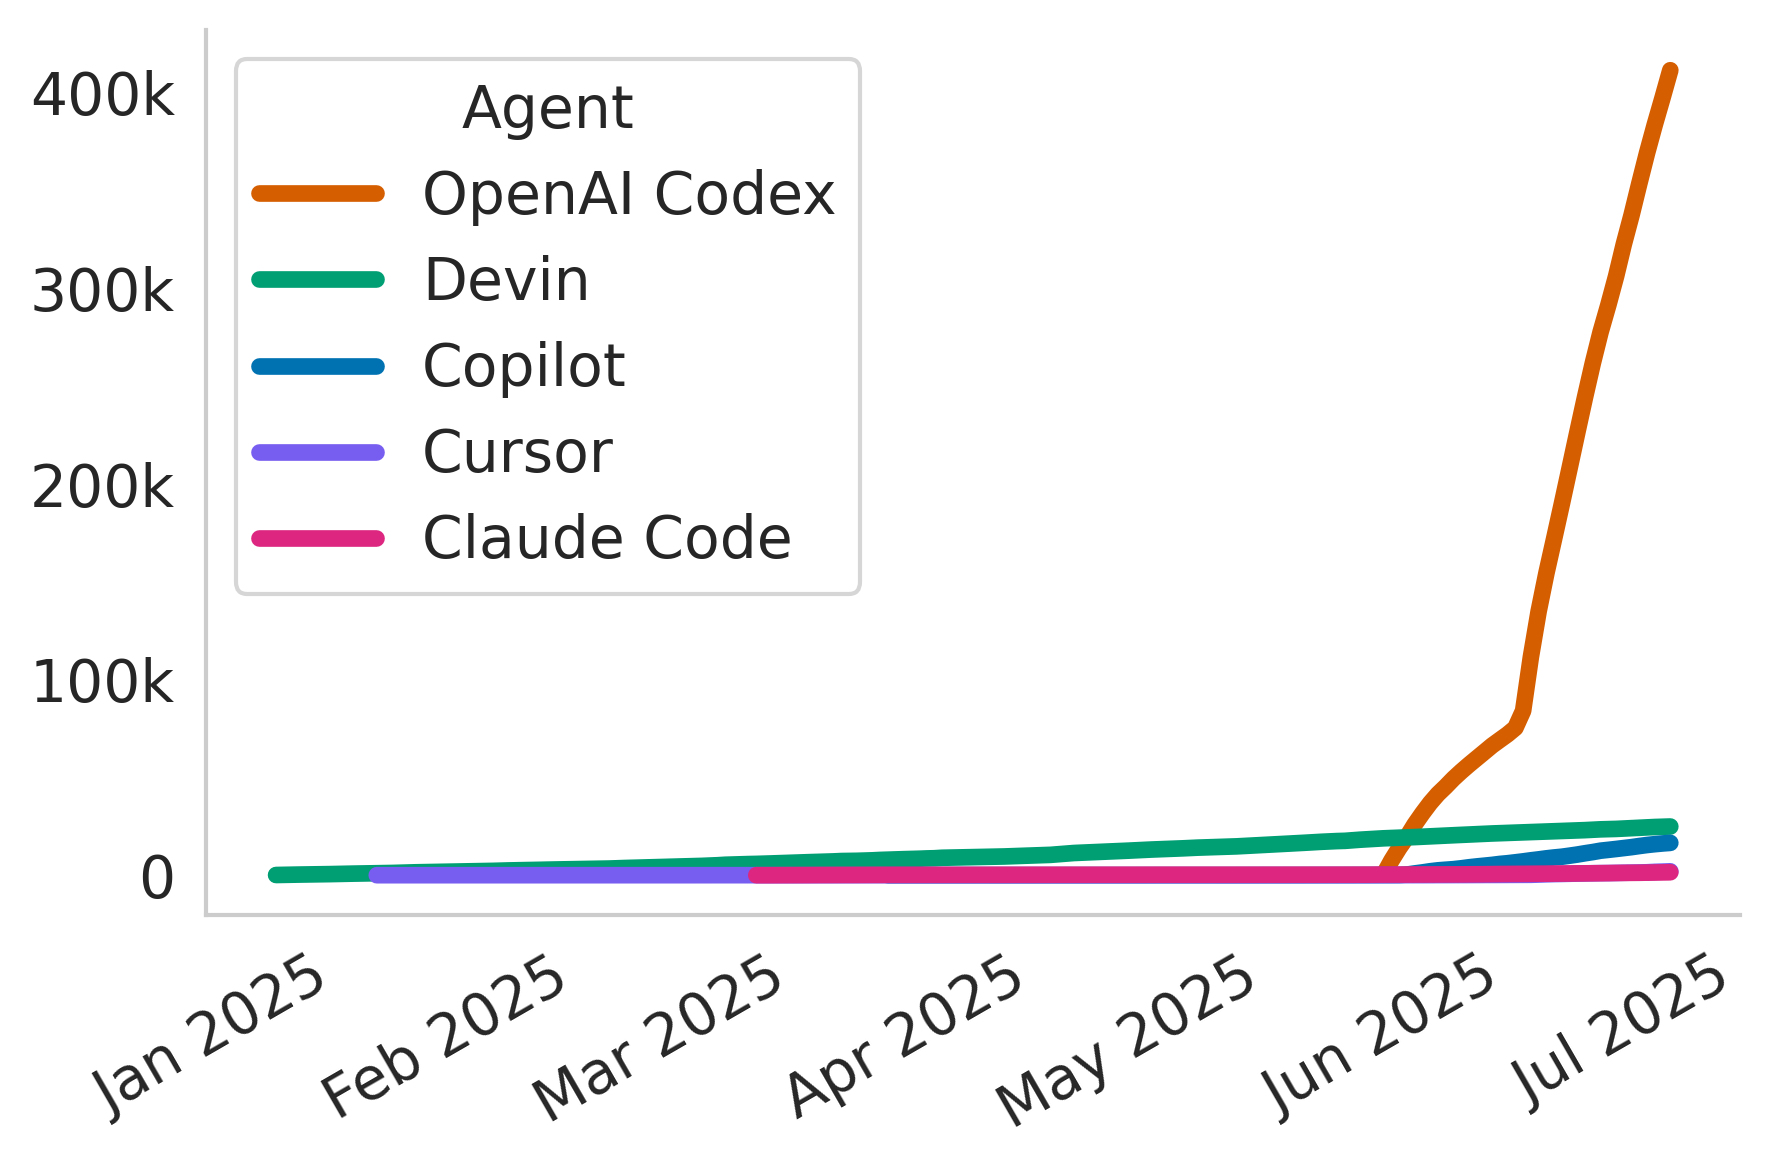

Wrote /home/leo/Projects/replication_package/AI_Teammates_in_SE3/figs/pr_cumulative.pdf


In [8]:
main(args_scope=False)

       agent  prs  pct_open  pct_closed  pct_merged  developers  repos
 Claude_Code  101 14.851485   32.673267   52.475248          68     61
     Copilot 1462 29.685363   32.079343   38.235294           1    215
      Cursor  144 27.083333   21.527778   51.388889          66     52
       Devin 2729  2.638329   48.442653   48.919018           1    130
       Human 6628  7.076041   16.188896   76.735063        2515    818
OpenAI_Codex 2686 13.440060   21.258377   65.301564         522    467
Summary of PRs per agent:
\begin{tabular}{lllllll}
\toprule
Agent & \# PR & \% Open PR & \% Closed PR & \% Merged PR & \# Developers & \# Repository \\
\midrule
Human & 6,628 & 7.1 & 16.2 & 76.7 & 2,515 & 818 \\
Devin & 2,729 & 2.6 & 48.4 & 48.9 & 1 & 130 \\
OpenAI Codex & 2,686 & 13.4 & 21.3 & 65.3 & 522 & 467 \\
Copilot & 1,462 & 29.7 & 32.1 & 38.2 & 1 & 215 \\
Cursor & 144 & 27.1 & 21.5 & 51.4 & 66 & 52 \\
Claude Code & 101 & 14.9 & 32.7 & 52.5 & 68 & 61 \\
Total & 13,750 & 10.1 & 25.4 & 64.4 & 

/tmp/ipykernel_68278/3691947013.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(generate_sorted_latex_with_total(summary[~popular_mask], combined_df))
/tmp/ipykernel_68278/3257788628.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


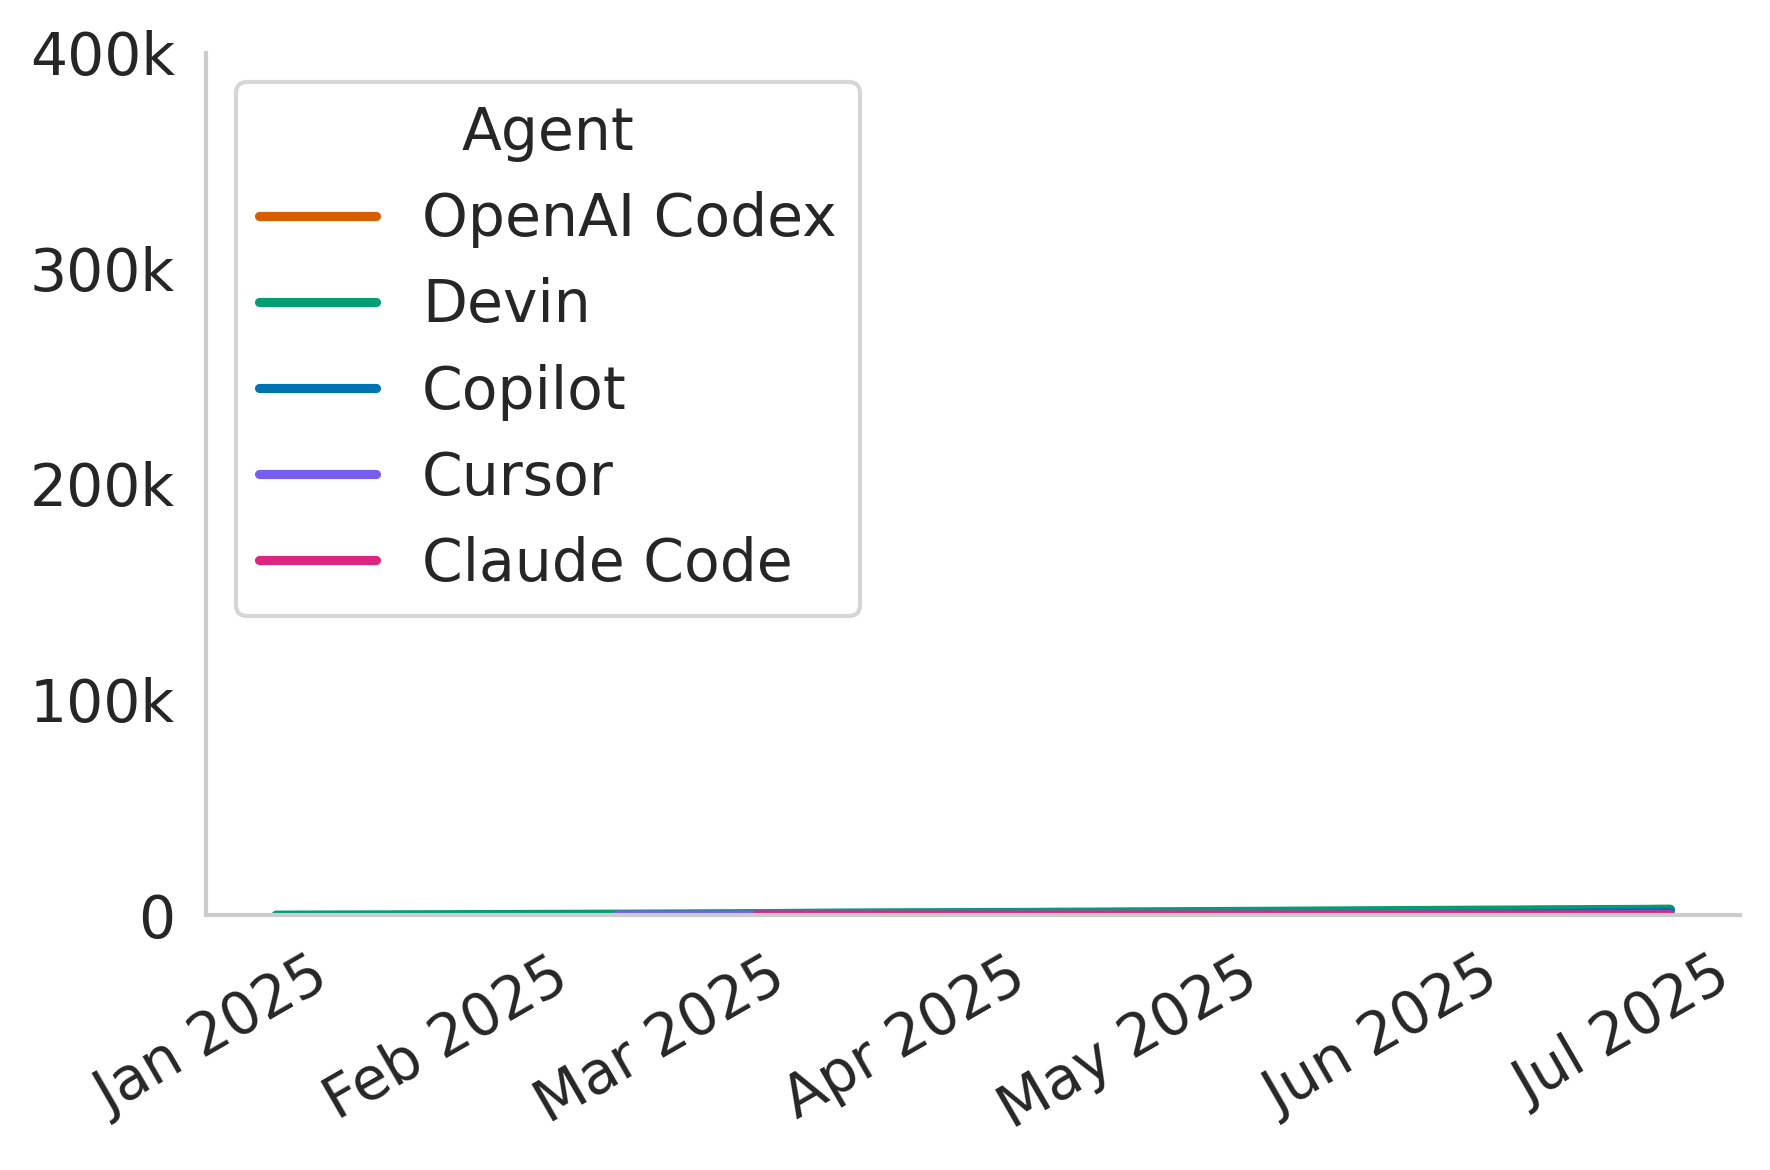

Wrote /home/leo/Projects/replication_package/AI_Teammates_in_SE3/figs/pr_cumulative_popular.pdf


In [5]:
main(args_scope=True)